In [1]:
## Creating mutli-class classification data
# # Import libraries
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [3]:
# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up 
    random_state=RANDOM_SEED
)

In [4]:
# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [5]:
# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

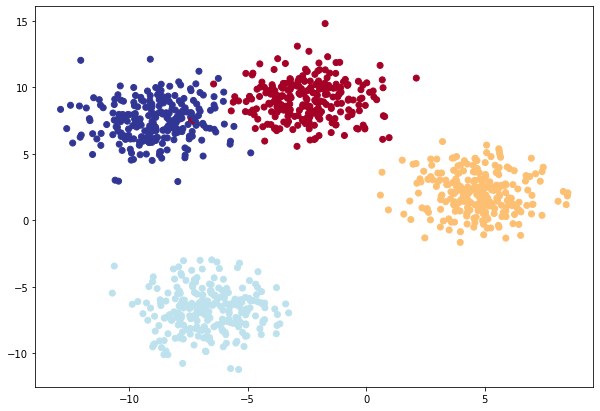

In [6]:
# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [16]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:
## Building a multi-class classification model in PyTorch
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [20]:
## Creating a loss function and optimizer for a multi-class PyTorch model
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.1) 

In [21]:
## Getting prediction probabilities for a multi-class PyTorch model
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model(X_blob_train.to(device))[:5]

tensor([[-0.5721,  0.8192,  0.0416,  0.2566],
        [ 0.6641,  1.7128,  1.2828, -0.3096],
        [ 0.4440, -1.6174, -0.0869, -0.8227],
        [ 0.3737, -0.7680,  0.1686, -0.6162],
        [ 0.6345,  1.2991,  1.1109, -0.3720]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [22]:
# How many elements in a single prediction sample?
model(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [24]:
# Make prediction logits with model
y_logits = model(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.4679,  1.0137,  0.1894,  0.2320],
        [ 1.1791,  1.1340,  1.4553, -0.7297],
        [ 0.2328, -1.3622, -0.1512, -0.6470],
        [-0.5153,  0.4213, -0.0604,  0.1457],
        [ 0.3966,  1.8800,  1.1448, -0.1173]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1070, 0.4709, 0.2065, 0.2155],
        [0.2922, 0.2793, 0.3852, 0.0433],
        [0.4350, 0.0883, 0.2963, 0.1805],
        [0.1416, 0.3612, 0.2231, 0.2742],
        [0.1232, 0.5429, 0.2603, 0.0737]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [25]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [26]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1070, 0.4709, 0.2065, 0.2155], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(1, device='cuda:0')


In [27]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [28]:
## Creating a training and testing loop for a multi-class PyTorch model
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model.train()

    # 1. Forward pass
    y_logits = model(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.78858, Acc: 23.88% | Test Loss: 0.58941, Test Acc: 75.00%
Epoch: 10 | Loss: 0.15354, Acc: 99.12% | Test Loss: 0.13873, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08612, Acc: 99.00% | Test Loss: 0.07732, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06319, Acc: 99.00% | Test Loss: 0.05508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05213, Acc: 99.00% | Test Loss: 0.04403, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04575, Acc: 99.12% | Test Loss: 0.03752, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04164, Acc: 99.12% | Test Loss: 0.03326, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03880, Acc: 99.12% | Test Loss: 0.03026, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03673, Acc: 99.12% | Test Loss: 0.02804, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03516, Acc: 99.12% | Test Loss: 0.02634, Test Acc: 99.50%


In [29]:
## Making and evaluating predictions with a PyTorch multi-class model
# Make predictions
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  9.2990,  14.7847,  -8.9240,  -4.0979],
        [  3.7613, -11.7373,   1.9944,   9.5170],
        [-14.5672, -21.0872,  13.8527,   5.3739],
        [  4.2394,   9.5825,  -4.8391,  -3.5972],
        [ 13.5100,   8.9997,  -9.1927,   1.8310],
        [  3.8560, -14.8367,   2.9075,  11.5132],
        [-14.2781, -17.5645,  12.6208,   3.3218],
        [ 10.6141,   3.3810,  -6.0371,   3.7745],
        [-16.1409, -27.4296,  16.5857,   8.4935],
        [ 11.4596,   5.3416,  -7.0575,   3.0063]], device='cuda:0')

In [30]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


In [32]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

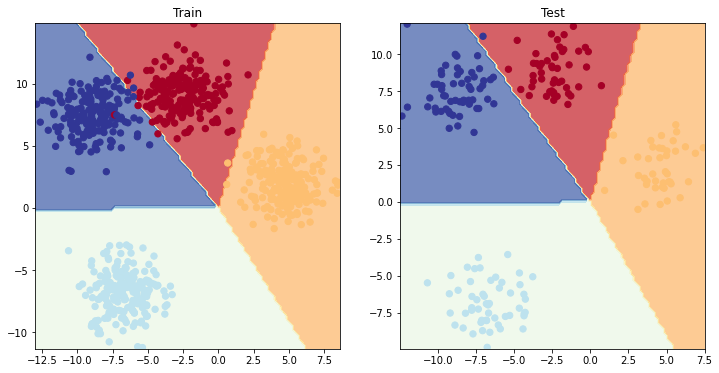

In [34]:
## Visualize decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)

In [35]:
## More classification evaluation metrics
# !pip -q install torchmetrics

from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy().to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

     |████████████████████████████████| 419 kB 30.1 MB/s 


tensor(0.9950, device='cuda:0')